# 气候观察者模型


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

## 一次运行

In [2]:
from shifting_baseline.abm import ClimateObservingModel
import matplotlib.pyplot as plt
from hydra import compose, initialize
from shifting_baseline.utils.log import get_logger, adjust_log_level

with initialize(config_path="../config", version_base=None):
    cfg = compose(config_name="config", overrides=["model=test"])

# 在 notebook 中动态调整日志等级
log = get_logger()
adjust_log_level(console_level="INFO", file_level="DEBUG")

# 运行模型
model = ClimateObservingModel(parameters=cfg)
model

环境变量加载: True (文件存在), True (加载成功)
INFO | 运行模式: test


<ClimateObservingModel-v0.7.5(init)>

In [3]:
model.run_model()

[15:13:08][WARNING][datacollector] No final reporters have been definedreturning empty DataFrame.


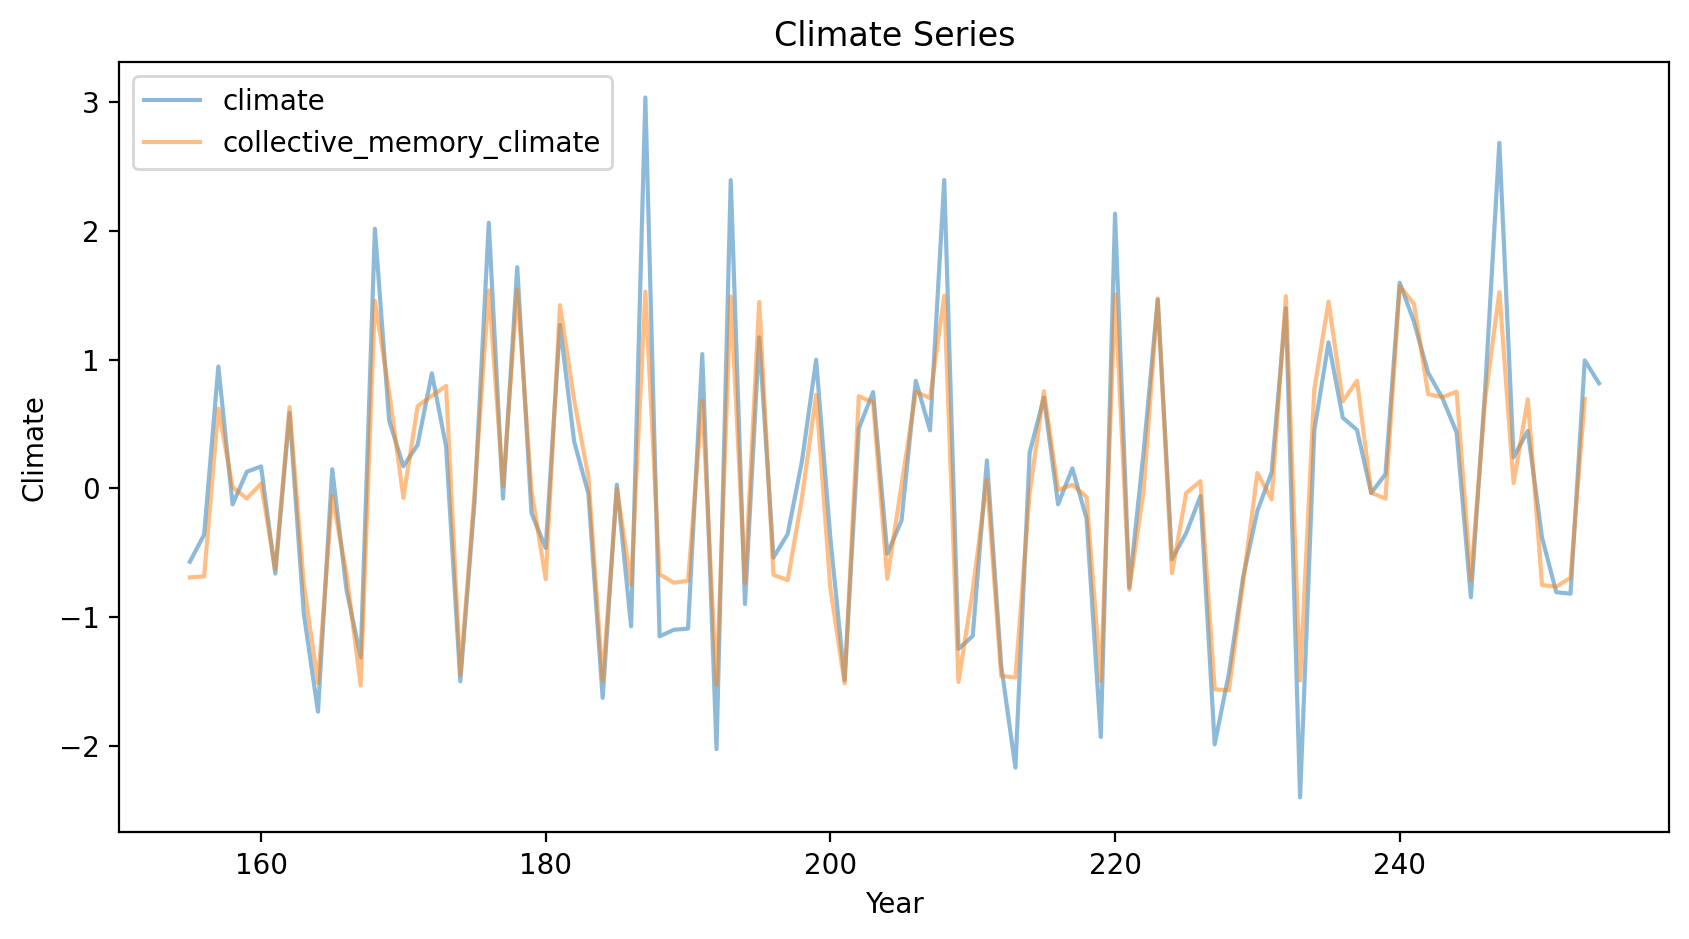

In [4]:
# 绘制气候序列和历史平均
fig, ax = plt.subplots(figsize=(10, 5))
model.climate_df.plot(ax=ax, label="Climate Series", alpha=0.5)
ax.set_title("Climate Series")
ax.set_xlabel("Year")
ax.set_ylabel("Climate")
ax.legend()
plt.show();

In [6]:
model.climate_df

,climate,collective_memory_climate
155,-0.570747,-0.692820
156,-0.360914,-0.684938
157,0.945856,0.618531
158,-0.125380,0.009101
159,0.127651,-0.079879
...,...,...
250,-0.383405,-0.752317
251,-0.807824,-0.764452
252,-0.819007,-0.696180
253,0.993689,0.694406


MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

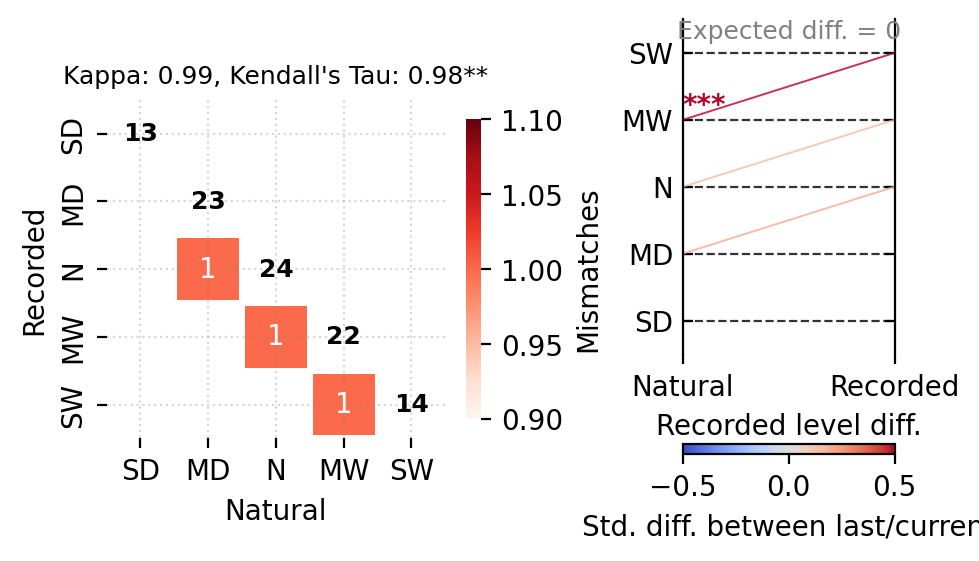

In [7]:
model.mismatch_report.generate_report_figure();

<Axes: >

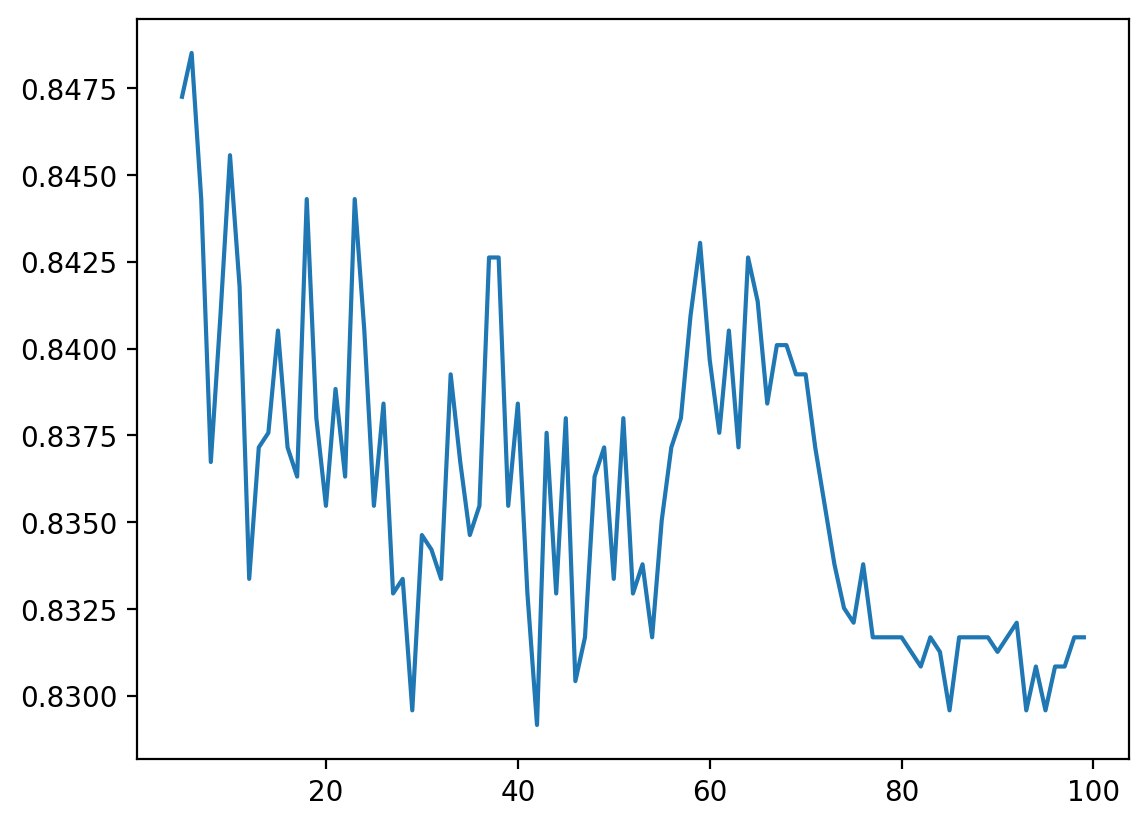

In [12]:
df = model.get_corr_curve()
df["kendall"].plot()

## 读取模型结果

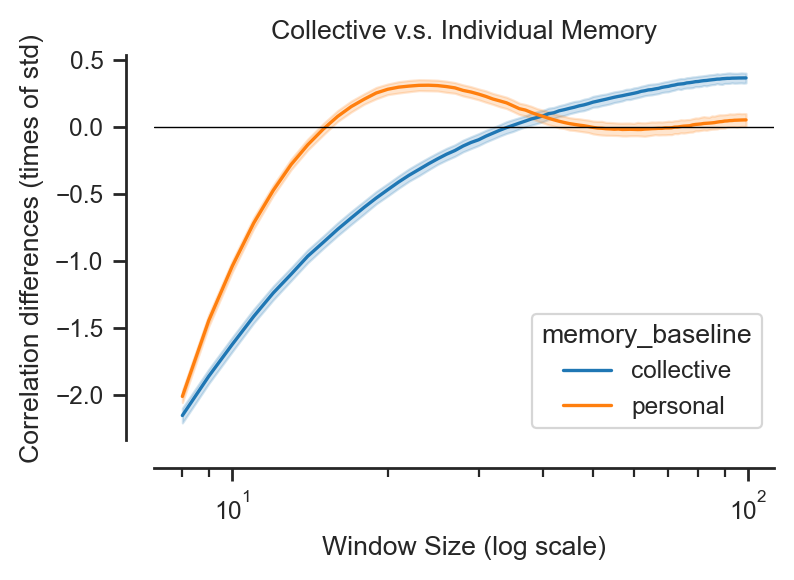

In [6]:
import yaml
from hydra import compose, initialize
import seaborn as sns
from matplotlib import pyplot as plt

with initialize(config_path="../config", version_base=None):
    cfg = compose(config_name="config")

path = Path(cfg.ds.abm)
# 设置seaborn风格
sns.set_style("ticks")
sns.set_context("paper")

datasets = []

for subdir in path.iterdir():
    if subdir.is_dir():
        corr_file = subdir / "correlations.csv"
        hydra_config = subdir / ".hydra" / "overrides.yaml"
        if corr_file.exists() and hydra_config.exists():
            # 读取 correlations.csv
            df = pd.read_csv(corr_file, index_col=0)
            long = df.melt(ignore_index=False).reset_index()
            long["run"] = subdir.name

            # 读取 hydra 配置
            with open(hydra_config, "r") as f:
                overrides = yaml.safe_load(f)
            # 解析每个参数
            param_dict = {}
            for item in overrides:
                if "=" in item:
                    key, value = item.split("=", 1)
                    # 只保留 how. 开头的参数（可选）
                    if key.startswith("how."):
                        key = key.replace("how.", "")
                    param_dict[key] = value
            # 将参数字典展开为多列
            for k, v in param_dict.items():
                long[k] = v

            datasets.append(long)

# 合并所有数据
# 去除掉所有表头的 model.
df_all = pd.concat(datasets, ignore_index=True)
for col in df_all.columns:
    try:
        df_all[col] = pd.to_numeric(df_all[col], errors="raise")
    except (ValueError, TypeError):
        pass
    if col.startswith("model."):
        df_all = df_all.rename(columns={col: col.replace("model.", "")})

# 1. 找每个 (rejudge, max_age, run) 下最大 correlation 的 Year
# 假设 df_all 已经有 'max_age', 'rejudge', 'variable', 'index', 'value'
df_all.dropna(inplace=True)
hue_col = "memory_baseline"
average_values = df_all.groupby(hue_col)["value"].mean()
std_values = df_all.groupby(hue_col)["value"].std()

for cate, mean in average_values.items():
    subset = df_all[df_all[hue_col] == cate]
    df_all.loc[subset.index, "diff"] = (subset["value"] - mean) / std_values[cate]

fig, ax = plt.subplots(figsize=(4, 2.5))
ax = sns.lineplot(data=df_all, x="index", y="diff", hue=hue_col, ax=ax)
ax.axhline(0, color="black", linewidth=0.5)
ax.set_xticks(np.arange(0, 101, 10))
ax.set_title("Collective v.s. Individual Memory")
ax.set_xlabel("Window Size (log scale)")
ax.set_ylabel("Correlation differences (times of std)")

sns.despine(offset=10)
plt.xscale("log")
plt.show();

上图清楚地展示了，只有在每个主体把自己的经验作为基线时，才会出现相关性先增强后减弱的动态格局。

### Max Age 作图

In [4]:
def find_max_correlation_by_all_params(
    df, target_col="value", time_col="index", exclude_cols=None
):
    """
    根据所有参数列分组，找到每组目标变量达到最大值的时间点

    Args:
        df: 数据框
        target_col: 目标变量列名（默认'value'）
        time_col: 时间列名（默认'index'）
        exclude_cols: 需要排除的列名列表（可选）

    Returns:
        DataFrame: 每组最大值对应的时间点和参数信息
    """
    if "min_age" in df.columns:
        df["max_length"] = df["max_age"].astype(int) - df["min_age"].astype(int)
        df = df[df["max_length"] > 0]
    elif "max_age" in df.columns:
        df["max_length"] = df["max_age"]
    else:
        pass
    # 默认排除的列
    default_exclude = {
        "index",
        "variable",
        "value",
        "run",
        "how",
        "max_age",
        "min_age",
        "diff",
    }

    if exclude_cols is not None:
        exclude_cols = set(exclude_cols)
        exclude_cols.update(default_exclude)
    else:
        exclude_cols = default_exclude

    # 自动识别参数列
    all_cols = set(df.columns)
    param_cols = list(all_cols - exclude_cols)

    print(f"使用的分组参数: {param_cols}")
    print(f"排除的列: {sorted(exclude_cols)}")

    # 定义分组函数
    def get_max_info(group):
        max_idx = group[target_col].idxmax()
        max_row = group.loc[max_idx]
        return pd.Series(
            {
                "max_year": max_row[time_col],
                "max_value": max_row[target_col],
                "group_size": len(group),
            }
        )

    # 执行分组和聚合
    result = (
        df.groupby(param_cols, dropna=False)
        .apply(get_max_info, include_groups=False)
        .reset_index()
    )

    # 重命名列以更清晰
    result = result.rename(
        columns={
            "max_year": f"Year_of_Max_{target_col}",
            "max_value": f"Max_{target_col}",
        }
    )

    return result


# 使用函数
max_points_comprehensive = find_max_correlation_by_all_params(df_all)
print(f"\n总共找到 {len(max_points_comprehensive)} 个参数组合")
max_points_comprehensive.head(10)

使用的分组参数: ['loss_rate', 'new_agents', 'model', 'memory_baseline']
排除的列: ['diff', 'how', 'index', 'max_age', 'min_age', 'run', 'value', 'variable']

总共找到 32 个参数组合


,loss_rate,new_agents,model,memory_baseline,Year_of_Max_value,Max_value,group_size
0,0.2,5,exp,collective,40.0,0.813662,9200.0
1,0.2,5,exp,personal,24.0,0.910088,9200.0
2,0.2,10,exp,collective,86.0,0.807839,9200.0
3,0.2,10,exp,personal,35.0,0.913596,9200.0
4,0.2,15,exp,collective,61.0,0.810078,9200.0
5,0.2,15,exp,personal,21.0,0.904825,9200.0
6,0.2,20,exp,collective,92.0,0.829787,9200.0
7,0.2,20,exp,personal,26.0,0.924123,9200.0
8,0.4,5,exp,collective,37.0,0.826652,9200.0
9,0.4,5,exp,personal,92.0,0.906579,9200.0


In [5]:
max_points_comprehensive.head()

,loss_rate,new_agents,model,memory_baseline,Year_of_Max_value,Max_value,group_size
0,0.2,5,exp,collective,40.0,0.813662,9200.0
1,0.2,5,exp,personal,24.0,0.910088,9200.0
2,0.2,10,exp,collective,86.0,0.807839,9200.0
3,0.2,10,exp,personal,35.0,0.913596,9200.0
4,0.2,15,exp,collective,61.0,0.810078,9200.0


<Axes: xlabel='new_agents', ylabel='Year of Max Correlation'>

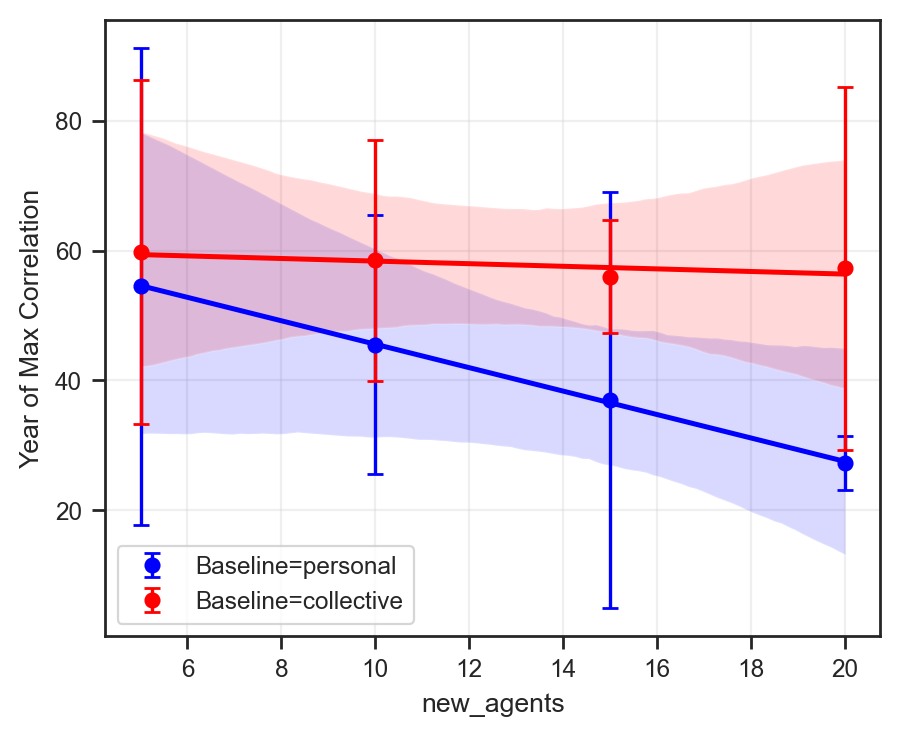

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def plot_maxlength_maxcorr_year(
    max_years,
    x_axis_col="max_length",
    y_axis_col="Year_of_Max_value",
):
    """Test"""
    plt.figure(figsize=(5, 4))
    ax = plt.gca()

    # 使用 scatterplot + errorbar 替代 pointplot
    for basline, color in zip(["personal", "collective"], ["blue", "red"]):
        subset = max_years[max_years["memory_baseline"] == basline]

        # 计算每个 max_age 的均值和标准差
        stats = (
            subset.groupby(x_axis_col)[y_axis_col].agg(["mean", "std"]).reset_index()
        )

        # 绘制错误棒
        ax.errorbar(
            stats[x_axis_col],
            stats["mean"],
            yerr=stats["std"],
            fmt="o",
            color=color,
            capsize=3,
            label=f"Baseline={basline}",
        )

        # 添加回归线
        sns.regplot(
            data=subset,
            x=x_axis_col,
            y=y_axis_col,
            scatter=False,
            color=color,
            ax=ax,
        )

    ax.set_ylabel("Year of Max Correlation")
    ax.set_xlabel(x_axis_col)
    ax.legend()
    ax.grid(True, alpha=0.3)
    return ax


plot_maxlength_maxcorr_year(max_points_comprehensive, x_axis_col="new_agents")

INFO | ================================================================================
INFO | 综合方差分析
INFO | ================================================================================
INFO | 数据概况:
INFO | 样本数: 32
INFO | 因变量: Year_of_Max_value
INFO | 分类变量: ['memory_baseline', 'loss_rate', 'new_agents']
INFO | 连续变量: []
INFO | 缺失值: 0
INFO | memory_baseline: F=4.3125, p=0.0465 *
INFO |   R²=0.1257, 显著: 是
INFO | loss_rate: F=0.2549, p=0.8572 
INFO |   R²=0.0266, 显著: 否
INFO | new_agents: F=0.5537, p=0.6499 
INFO |   R²=0.0560, 显著: 否
INFO | 多因素方差分析:
INFO | 仅主要效应模型: R²=0.21, AIC=301.96
INFO | 包含交互效应模型: R²=0.67, AIC=304.10
INFO | 推荐模型: main_effects
INFO | 统计摘要表:
INFO | 
             变量 类型   F统计量     p值     R² 显著性 显著性标记
memory_baseline 分类 4.3125 0.0465 0.1257   是     *
      loss_rate 分类 0.2549 0.8572 0.0266   否      
     new_agents 分类 0.5537 0.6499 0.0560   否      


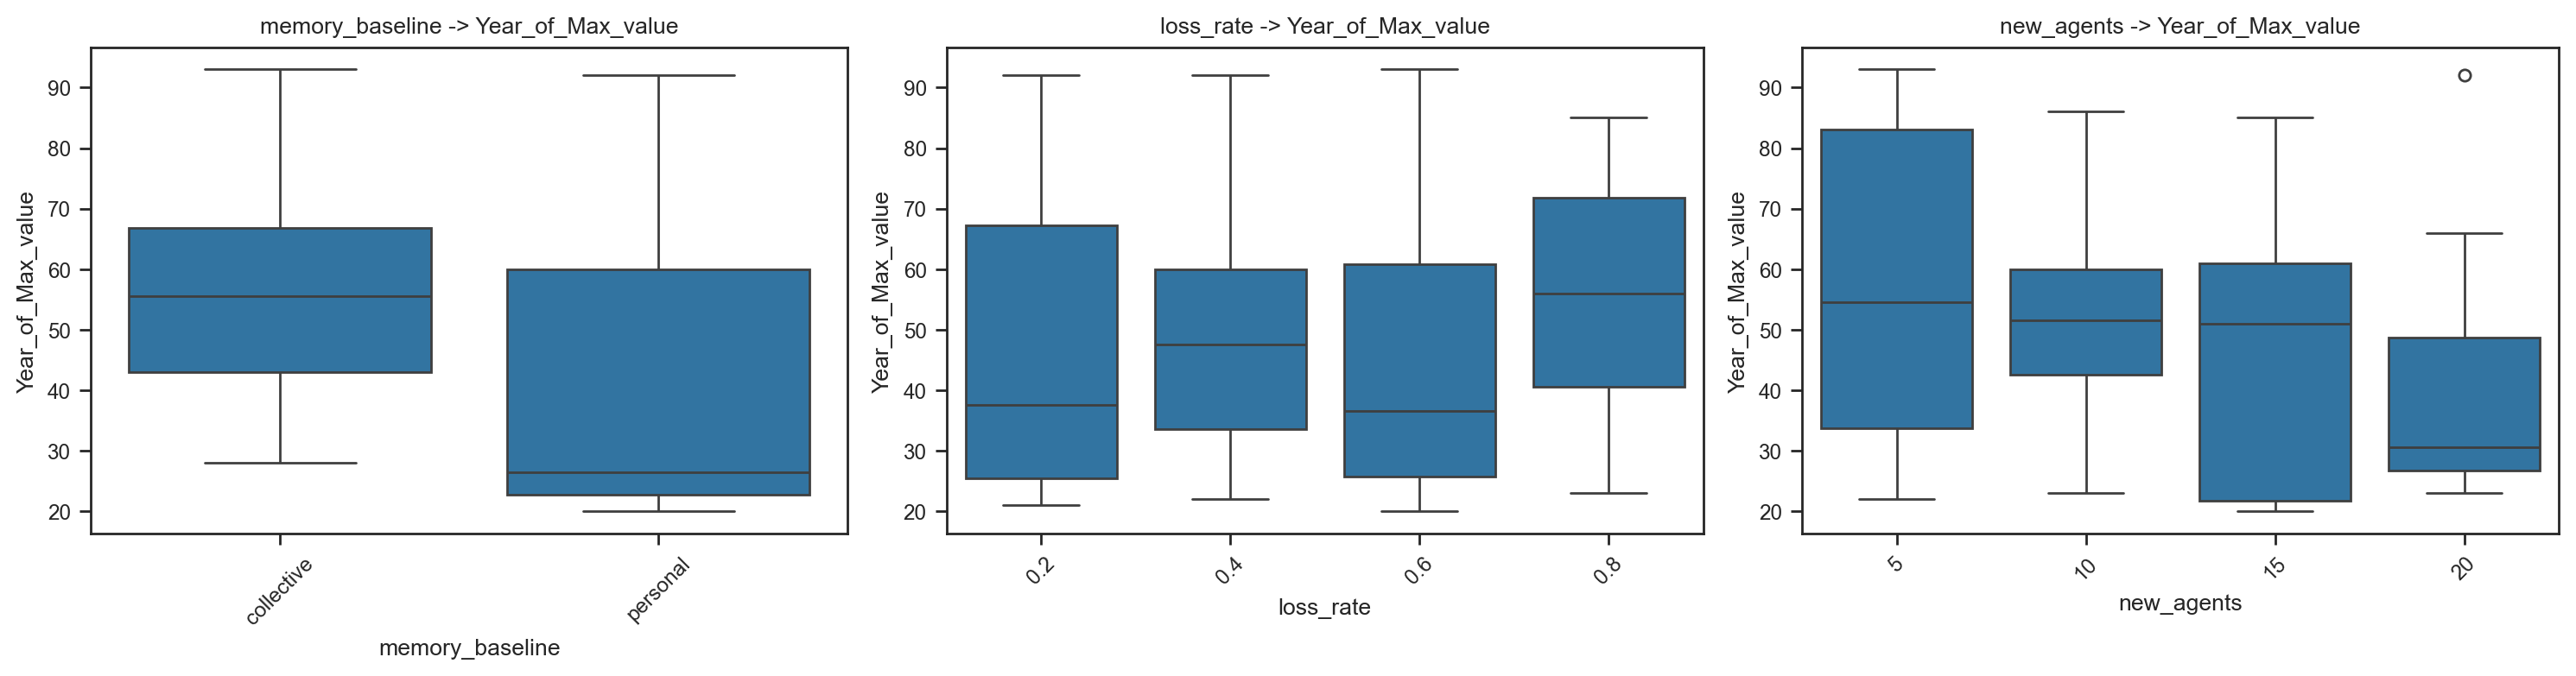

In [8]:
from shifting_baseline.utils.anova import comprehensive_anova_analysis

results = comprehensive_anova_analysis(
    df=max_points_comprehensive,
    target_col="Year_of_Max_value",
    categorical_cols=["memory_baseline", "loss_rate", "new_agents"],
    continuous_cols=[],  # 没有连续变量
)